# 0.前期准备



In [1]:
## import packages which we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
%matplotlib inline  

In [2]:
## python env
import sys
print(sys.version)

3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


### 0.1 任务说明

本任务的目的是基于基因序列的ATCG序列数据进行基因功能的预测。数据包含人、狗、猩猩等的基因序列数据以及对应的数据基因功能标签。希望利用不同的分类方法（Bayes，Logistic回归，人工神经网络，SVM，Random Forest等）来进行基因功能的预测，并比较不同的分类方法在该数据集上的最终效果。

### 0.2 数据集初步分析

因为数据集太大，因此不随着作业上传到教学平台，仅仅上传**代码和报告部分**。另开设了一个githup仓库上传了整个项目。\
githup网址：

In [3]:
## read dataset
sys.path.append('../data')
human = pd.read_table('../data/human_data.txt')
chimp = pd.read_table('../data/chimp_data.txt')
dog = pd.read_table('../data/dog_data.txt')

## take a look at the data
print('There are {} gene sequences of human, {} of dog, and {} of chimpanzee.\
'.format(human.shape[0], dog.shape[0], chimp.shape[0]))
human.head()

There are 4380 gene sequences of human, 820 of dog, and 1682 of chimpanzee.


,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


基于数据初步分析可以看到，人类基因序列数据量最大，因此计划从**人类基因组数据**中划分训练集和测试集，在训练集上训练并在人类基因组测试集上测试模型效果，并在狗、猩猩数据集上预测来分析模型的**泛化性**。


# 1.数据预处理

该部分包含对序列数据进行预处理的工作。首先，因为不同的基因组序列数据长度不一致，为了便于后续训练，我利用自然语言处理中的分词方法对序列进行k-mers划分，继而每个序列可以看作自然语言处理中的语句，然后利用sklearn中的词袋模型对序列进行词向量建模。最后利用sklearn库进行训练-测试数据集划分。

### 1.1 词向量划分

首先对序列进行k-mers划分。默认的k值为6，因为3个碱基对构成一个密码子，因此尽量选择3的整数倍，在此选择6作为**流程测试的参数**比较合适，在后续**探索最优模型**阶段会对不同的k值和不同的词向量划分参数进行训练，针对结果给出最优k值和词向量划分参数。

In [4]:
from data_preprocess import *
## default k-mers size.
sz = 6

dog = seq2words(dog, sz)
human = seq2words(human, sz)
chimp = seq2words(chimp, sz)
human.head()

The sequence is too short.



,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


接下来根据已经划分好的序列词向量制作训练集和测试集。

In [5]:
## shuffle data and split to them to feature and label

h_text, h_y = df2text(human)
c_text, c_y = df2text(chimp)
d_text, d_y = df2text(dog)

利用Sklearn提供的CountVectorizer函数构建词袋子模型，将文本转换为词向量：

In [6]:
## Creating the Bag of Words model using CountVectorizer()

from sklearn.feature_extraction.text import CountVectorizer
# (4,4) is a superparameter which we will chose later
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(h_text)
X_c = cv.transform(c_text)
X_d = cv.transform(d_text)

查看数据集中label是否均匀，画出图像如下：

<AxesSubplot:>

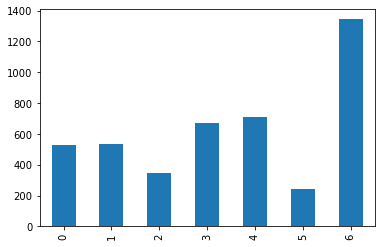

In [7]:
human['class'].value_counts().sort_index().plot.bar()

### 1.2 训练集划分
从结果上看，数据label分布相对较为均匀，仅label—5较少，但也差距不大，暂不用考虑**label分布不均匀**的问题，该问题可采用重采样方式解决。\
接下来划分训练集和测试集：

In [8]:
from sklearn.model_selection import train_test_split

## split train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, h_y, test_size=0.2, shuffle=True)

# 2.不同模型划分的效果

使用Bayes，Logistic回归，人工神经网络，SVM，Random Forest等在该训练集上进行训练，并对比结果。

In [10]:
## Used to calculate metric for the models.
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn import metrics

### 2.1 Beyes方法


利用grip search方法找到最优的模型参数：

In [11]:
### Naive Bayes Classifier ###

from sklearn.naive_bayes import MultinomialNB, GaussianNB
import matplotlib.pyplot as plt

## parameter selection for multi_NB model
loss_1 = []
best_sc = 0
best_para = 0
al_list_1 = np.linspace(0, 1, 50)
for al in al_list_1:
    Multi_NB = MultinomialNB(alpha=al)

    score = cross_val_score(Multi_NB, X_train, Y_train, cv=5, scoring='f1_macro')
    sc = score.mean()
    loss_1.append(score.mean())

    if sc > best_sc:
        best_sc = sc
        best_para = al
NB_clf = MultinomialNB(alpha=best_para)

/data2/hyzhang/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/data2/hyzhang/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/data2/hyzhang/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/data2/hyzhang/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/data2/hyzhang/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:

最优模型参数为：

In [12]:
best_para

0.14285714285714285

查看贝叶斯模型的分类效果：

In [13]:
from Metrics import *

## NB_result
NB_clf.fit(X_train, Y_train)

print('\n**Rresult of human data:\n')
h_a, h_p, h_r, h_f = print_metrics(NB_clf, X_test, Y_test)

print('\n**Rresult of chimpanzee data:\n')
c_a, c_p, c_r, c_f = print_metrics(NB_clf, X_c, c_y)

print('\n**Rresult of dog data:\n')
d_a, d_p, d_r, d_f = print_metrics(NB_clf, X_d, d_y)

NB_res = [h_a, h_p, h_r, h_f, c_a, c_p, c_r, c_f, d_a, d_p, d_r, d_f]


**Rresult of human data:

Confusion matrix

Predicted    0   1   2    3    4   5    6
Actual                                   
0          119   0   0    0    2   0    6
1            0  97   0    0    2   0    0
2            0   0  80    1    0   0    0
3            0   0   0  124    1   0    0
4            3   0   0    0  130   0    3
5            2   0   0    0    0  31    1
6            2   0   0    0    1   0  271
accuracy = 0.973 
precision = 0.973 
recall = 0.973 
f1 = 0.973

**Rresult of chimpanzee data:

Confusion matrix

Predicted    0    1    2    3    4    5    6
Actual                                      
0          230    0    0    0    1    0    3
1            0  182    0    0    3    0    0
2            0    0  144    0    0    0    0
3            0    0    0  223    2    0    3
4            2    0    0    0  257    0    2
5            1    0    0    0    0  107    1
6            3    0    0    0    0    0  518
accuracy = 0.988 
precision = 0.988 
recall = 0.988 
f1 = 

从结果上看，在人类基因组数据的测试集上可以达到**97.3%**的准确率，并且在dog和chimpanzee数据集上都达到90%以上的准确率，分类模型的效果比较好。

### 2.2 SVM方法

利用sklearn库实现SVM方法进行分类，挑选最优参数：

In [21]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

SVM_clf = svm.SVC(class_weight='balanced', probability=True)

## find best parameter
search_space = {'C': np.logspace(-3, 3, 5)}
gridsearch = GridSearchCV(SVM_clf, param_grid=search_space, scoring='f1_macro', refit=True, cv=10, n_jobs=-1)
gridsearch.fit(X_train,Y_train)

SVM_clf = gridsearch.best_estimator_
SVM_clf.fit(X_train, Y_train)


GridSearchCV(cv=10, estimator=SVC(class_weight='balanced', probability=True),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03])},
             scoring='f1_macro')

In [28]:


## load model which was trained before
if os.path.isfile('SVM.pkl'):
    SVM_clf = joblib.load('SVM.pkl')

print('\n**Rresult of human data:\n')
h_a, h_p, h_r, h_f = print_metrics(SVM_clf, X_test, Y_test)

print('\n**Rresult of chimpanzee data:\n')
c_a, c_p, c_r, c_f = print_metrics(SVM_clf, X_c, c_y)

print('\n**Rresult of dog data:\n')
d_a, d_p, d_r, d_f = print_metrics(SVM_clf, X_d, d_y)

SVM_res = [h_a, h_p, h_r, h_f, c_a, c_p, c_r, c_f, d_a, d_p, d_r, d_f]


**Rresult of human data:

Confusion matrix

Predicted    0   1   2    3    4   5    6
Actual                                   
0          119   0   0    0    0   0    8
1            0  98   0    0    0   0    1
2            0   0  80    0    0   0    1
3            0   0   0  120    0   0    5
4            0   0   0    0  135   0    1
5            0   0   0    0    1  30    3
6            0   0   0    0    0   0  274
accuracy = 0.977 
precision = 0.979 
recall = 0.977 
f1 = 0.977

**Rresult of chimpanzee data:

Confusion matrix

Predicted    0    1    2    3    4    5    6
Actual                                      
0          221    0    0    0    0    0   13
1            0  183    0    0    0    0    2
2            0    0  139    0    0    0    5
3            0    0    0  215    0    0   13
4            0    0    0    0  258    0    3
5            0    0    0    0    0  107    2
6            0    0    0    0    0    0  521
accuracy = 0.977 
precision = 0.979 
recall = 0.977 
f1 = 

可以看到SVM方法在human和chimpanzee数据集上结果还比较好，但在dog数据集上效果较差。

In [15]:
import joblib
joblib.dump(SVM_clf,'SVM.pkl')

NameError: name 'SVM_clf' is not defined

### 2.3 logistics regression方法

In [30]:
from sklearn.linear_model import LogisticRegression
import math

## find parameter and get the best model trained.
best_C = 1e-3
bset_sc = 0
Cs = np.logspace(-3, 3, 10)
loss_3 = []
for c in Cs:
    logreg = LogisticRegression(C = c)
    logreg.fit(X_train, Y_train)
    
    score = cross_val_score(logreg, X_train, Y_train, cv=5, scoring='f1_macro')
    sc = score.mean()
    loss_3.append(score.mean())

    if sc > best_sc:
        best_sc = sc
        best_C = c
LogisticR_clf = LogisticRegression(C = best_C)
LogisticR_clf.fit(X_train, Y_train)

KeyboardInterrupt: 

In [29]:
from Metrics import *

## load model which was trained before
if os.path.isfile('LogR.pkl'):
    LogisticR_clf = joblib.load('LogR.pkl')


print('\n**Rresult of human data:\n')
h_a, h_p, h_r, h_f = print_metrics(LogisticR_clf, X_test, Y_test)

print('\n**Rresult of chimpanzee data:\n')
c_a, c_p, c_r, c_f = print_metrics(LogisticR_clf, X_c, c_y)

print('\n**Rresult of dog data:\n')
d_a, d_p, d_r, d_f = print_metrics(LogisticR_clf, X_d, d_y)

LogisticR_res = [h_a, h_p, h_r, h_f, c_a, c_p, c_r, c_f, d_a, d_p, d_r, d_f]


**Rresult of human data:

Confusion matrix

Predicted    0   1   2    3    4   5    6
Actual                                   
0          121   0   0    3    1   0    2
1            0  99   0    0    0   0    0
2            0   0  81    0    0   0    0
3            0   0   0  124    1   0    0
4            0   0   0    0  135   0    1
5            1   0   0    0    0  31    2
6            0   0   0    0    0   0  274
accuracy = 0.987 
precision = 0.988 
recall = 0.987 
f1 = 0.987

**Rresult of chimpanzee data:

Confusion matrix

Predicted    0    1    2    3    4    5    6
Actual                                      
0          228    1    0    0    0    0    5
1            0  185    0    0    0    0    0
2            0    0  144    0    0    0    0
3            1    0    0  219    6    0    2
4            1    0    0    0  259    0    1
5            0    0    0    0    0  108    1
6            0    0    0    1    0    0  520
accuracy = 0.989 
precision = 0.989 
recall = 0.989 
f1 = 

从结果上看逻辑回归模型在人类数据集和非常类似的猩猩数据集上有非常高的预测效果，但在dog数据集上效果较差。

In [ ]:
## save model
joblib.dump(LogisticR_clf,'LR.pkl')

### 2.4 Random Forest 方法


In [20]:
## find parameter and get the best model trained.
from sklearn.ensemble import RandomForestClassifier     #导入需要的模块
from sklearn.model_selection import GridSearchCV


Rf_clf = RandomForestClassifier()                      #实例化
# Rfc = rfc.fit(X_train,y_train)  
## find best parameter
search_space = {'n_estimators': range(10, 100, 9)}
gridsearch = GridSearchCV(Rf_clf, param_grid=search_space, scoring='f1_macro', refit=True, cv=10, n_jobs=-1)
gridsearch.fit(X_train,Y_train)

Rf_clf = gridsearch.best_estimator_
Rf_clf.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=82)

In [22]:
from Metrics import *

## load model which was trained before
if os.path.isfile('Rf.pkl'):
    Rf_clf = joblib.load('Rf.pkl')

print('\n**Rresult of human data:\n')
h_a, h_p, h_r, h_f = print_metrics(Rf_clf, X_test, Y_test)

print('\n**Rresult of chimpanzee data:\n')
c_a, c_p, c_r, c_f = print_metrics(Rf_clf, X_c, c_y)

print('\n**Rresult of dog data:\n')
d_a, d_p, d_r, d_f = print_metrics(Rf_clf, X_d, d_y)

Rf_res = [h_a, h_p, h_r, h_f, c_a, c_p, c_r, c_f, d_a, d_p, d_r, d_f]


**Rresult of human data:

Confusion matrix

Predicted    0   1   2    3    4   5    6
Actual                                   
0          110   0   0    9    1   0    7
1            0  90   0    5    1   0    3
2            3   0  75    3    0   0    0
3            1   0   0  123    0   0    1
4            4   0   0    9  117   0    6
5            4   0   0    0    0  24    6
6            3   0   0   15    1   0  255
accuracy = 0.906 
precision = 0.917 
recall = 0.906 
f1 = 0.908

**Rresult of chimpanzee data:

Confusion matrix

Predicted    0    1    2    3    4    5    6
Actual                                      
0          229    2    0    2    1    0    0
1            0  183    0    1    0    0    1
2            1    0  143    0    0    0    0
3            3    0    0  222    1    0    2
4            1    0    0    3  255    0    2
5            0    0    0    0    0  106    3
6            1    0    0    6    3    0  511
accuracy = 0.980 
precision = 0.981 
recall = 0.980 
f1 = 

从结果上看随机森林模型在人类数据集和非常类似的猩猩数据集上有非常高的预测效果，但在dog数据集上效果较差。

In [23]:
## save model
joblib.dump(Rf_clf,'Rf.pkl')

['Rf.pkl']

### 2.5 Neural Network方法

In [24]:
## find parameter and get the best model trained.
from sklearn.neural_network import MLPClassifier    #导入需要的模块
from sklearn.model_selection import GridSearchCV


Neural_clf = MLPClassifier(solver='adam', alpha=1e-5)
# Rfc = rfc.fit(X_train,y_train)  
## find best parameter
search_space = {'hidden_layer_sizes': range(3, 10)}
gridsearch = GridSearchCV(Neural_clf, param_grid=search_space, scoring='f1_macro', refit=True, cv=10, n_jobs=-1)
gridsearch.fit(X_train,Y_train)

Neural_clf = gridsearch.best_estimator_
Neural_clf.fit(X_train, Y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=8)

In [34]:
from Metrics import *

## load model which was trained before
if os.path.isfile('Neural.pkl'):
    Neural_clf = joblib.load('Neural.pkl')

print('\n**Rresult of human data:\n')
h_a, h_p, h_r, h_f = print_metrics(Neural_clf, X_test, Y_test)

print('\n**Rresult of chimpanzee data:\n')
c_a, c_p, c_r, c_f = print_metrics(Neural_clf, X_c, c_y)

print('\n**Rresult of dog data:\n')
d_a, d_p, d_r, d_f = print_metrics(Neural_clf, X_d, d_y)

Neural_res = [h_a, h_p, h_r, h_f, c_a, c_p, c_r, c_f, d_a, d_p, d_r, d_f]


**Rresult of human data:

Confusion matrix

Predicted    0   1   2    3    4   5    6
Actual                                   
0          113   1   0    1    5   0    7
1            0  99   0    0    0   0    0
2            0   0  79    2    0   0    0
3            0   0   0  123    1   0    1
4            0   2   1    0  130   0    3
5            0   0   0    0    0  33    1
6            0   1   0    4    2   0  267
accuracy = 0.963 
precision = 0.964 
recall = 0.963 
f1 = 0.963

**Rresult of chimpanzee data:

Confusion matrix

Predicted    0    1    2    3    4    5    6
Actual                                      
0          224    0    0    0    3    0    7
1            0  185    0    0    0    0    0
2            0    0  144    0    0    0    0
3            0    0    0  223    2    0    3
4            0    1    0    0  258    0    2
5            0    0    0    0    0  108    1
6            0    2    0    0    2    0  517
accuracy = 0.986 
precision = 0.987 
recall = 0.986 
f1 = 

从结果上看神经网络模型在人类数据集和非常类似的猩猩数据集上有非常高的预测效果，但在dog数据集上效果较差。

In [27]:
## save model
joblib.dump(Neural_clf,'Neural.pkl')

['Neural.pkl']

# 3.各方法结果总结、分析

在上一部分已经得到了5种模型在该human数据集下训练得到最优参数的情况，并获得了各模型在dog以及chimpanzee数据集上的结果，在本part将结果进行可视化分析，对比不同模型在该数据集上的效果。

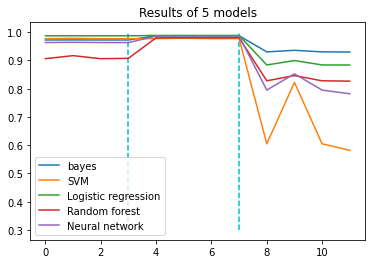

In [38]:
## plot the result curve
clf_names = ['bayes', 'SVM', 'Logistic regression', 'Random forest', 'Neural network']

results = [NB_res, SVM_res, LogisticR_res, Rf_res, Neural_res]

plt.figure()
for res, clf_ in zip(results, clf_names):
    plt.plot(res)
    
plt.legend(clf_names)
plt.vlines(3, 0.3, 1, colors = "c", linestyles = "dashed") 
plt.vlines(7, 0.3, 1, colors = "c", linestyles = "dashed") 
plt.title('Results of 5 models')
plt.show()

上图中两虚线划分数据集，左侧为human数据集，中间为chimpanzee，最右侧为dog数据集，每个数据集的4个点分别代表accuracy、precision、recall、f1评价指标的值。从结果上得到结论如下：\
**1.除了随机森林模型之外，其余各模型在human和chimp数据集上的结果都比较好，能够达到95%以上，并且模型之间结果相差不大。这表明模型训练的结果比较好，并且在chimp数据集上的泛化性较强，反映了chimp和human的序列相似性和同源性。**\
**2.所有模型在dog数据集上的泛化效果都显著低于在前两个数据集上的结果，反映了human序列和dog的区别，模型可能没法很好地利用从human数据集中获得的特征来预测dog的基因序列信息。**\
**3.比较各模型的结果，各模型在前两个数据集上结果差别不大，而贝叶斯方法在dog数据集上结果最好，其次是逻辑回归、随机森林、神经网络模型，SVM的结果最差。**